# Load dependencies

In [91]:
!pip install openpyxl
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import torch
from torch import nn
import pandas as pd
import torch.optim as optim
import torch.utils as utils
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
import warnings
import torch.nn.functional as F
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable


[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: C:\Program Files\Python311\python.exe -m pip install --upgrade pip


# Experimrntal setups (hyperparameters)

In [92]:
torch.manual_seed(2022)
#Number of neurons in each hidden layer
n_hidden = 30


#Learning rate
lr = 0.0001

#Batch size
bs = 256

#number of epochs
num_epochs = 800

#confudence level
cl = 0.8


# Load Datasets

In [93]:

drop_list = []
yvar = "target"
raw_data=pd.read_csv('G://yangshuo4.csv')

# Data shuffling and normalization

In [94]:
def stand_sca(data):
    data = (data - data.mean()) / data.std()
    return data

# shuffle your data
raw_data = raw_data.sample(frac=1).reset_index(drop=True)
all_data = raw_data.copy()

# Select all columns except the last for normalization
all_data.iloc[:, :-1] = all_data.iloc[:, :-1].transform(stand_sca)

# Drop useless variables

# Dataset division

In [95]:
n_row = all_data.shape[0]
n_train = int((n_row/5) * 2)
n_cal = int(n_row/5)
n_val = int(n_row/5)
n_test = int(n_row/5)

train_data = all_data[:n_train]
cal_data = all_data[n_train:n_train+n_cal]
val_data = all_data[n_train+n_cal:n_train+n_cal+n_val]
test_data = all_data[n_train+n_cal+n_val:]


train_features=torch.tensor(train_data.drop(yvar, axis = 1).values,dtype=torch.float) 
val_features=torch.tensor(val_data.drop(yvar, axis = 1).values,dtype=torch.float)
cal_features=torch.tensor(cal_data.drop(yvar, axis = 1).values,dtype=torch.float)
test_features=torch.tensor(test_data.drop(yvar, axis = 1).values,dtype=torch.float)

train_labels=torch.tensor(train_data[yvar].values,dtype=torch.float).view(-1,1)
val_labels=torch.tensor(val_data[yvar].values,dtype=torch.float).view(-1,1)
cal_labels=torch.tensor(cal_data[yvar].values,dtype=torch.float).view(-1,1)
test_labels=torch.tensor(test_data[yvar].values,dtype=torch.float).view(-1,1)

n_feature = all_data.shape[1]-1

# Define the loss function

In [96]:
#MSE loss
loss = nn.MSELoss()

# Baseline Neural Network Structure

In [97]:

# A standard NN with 2 hidden layers and one output unit, leaky relu activation function and dropout
class BaseNet(nn.Module):
    def __init__(self, n_feature, n_hidden):
        super(BaseNet, self).__init__()
        self.hidden1 = nn.Linear(n_feature, n_hidden)
        self.hidden2 = nn.Linear(n_hidden, n_hidden)
        self.predict = nn.Linear(n_hidden, 1)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = self.dropout(x)
        x = F.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.predict(x)
        return x
    

def get_net(feature_num, hidden_num):
    net=BaseNet(feature_num,hidden_num)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

# Training functions

In [98]:
# def train(net, train_features,train_labels,val_features,val_labels,
#           num_epochs,learning_rate,batch_size,wd):
    

def train(model, X_train, y_train, epochs, nn_batch_size, nn_learning_rate):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=nn_learning_rate)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        # shuffle data
        indices = torch.randperm(len(X_train))
        X_train = X_train[indices]
        y_train = y_train[indices]
        
        
        #mini-batch gradient descent
        for i in range(0, len(X_train), nn_batch_size):
            X_batch = torch.FloatTensor(X_train[i:i+nn_batch_size])
            y_batch = torch.FloatTensor(y_train[i:i+nn_batch_size]).reshape(-1, 1)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
    return losses
        
        

# Conformal predictor functions

In [113]:
#Calculate the normalized non-conformity measures of the calibration set
def torch_ncm(mnet,dnet, xs, ys):
    pm = mnet(xs)
    pd0 = dnet(xs)
    pd1 = torch.exp(pd0)
    return((ys - pm).abs() / pd1)

#Generate the prediction intervals
def regions(mnet,dnet, test_features, test_labels, alphaq):
    xs = test_features
    pm = mnet(xs)
    pd0 = dnet(xs)
    pd1 = torch.exp(pd0)
    lower = pm - alphaq*pd1
    upper = pm + alphaq*pd1 
    return lower.detach().numpy(), upper.detach().numpy()

#Helper function 
def list_le(a,b):
    tlist=[]
    for i in range(len(a)):
        tlist.append(a[i]<=b[i])
    return tlist 
    
#Helper function
def list_and(a,b):
    tlist=[]
    for i in range(len(a)):
        tlist.append(a[i]==b[i])
    return tlist

#Calcullate the final experimental result (PICP and MPIW)
def acc_ineff(test_labels, lower, upper):
    ys = test_labels.detach().numpy().reshape(-1).tolist()
    return np.mean(list_and(list_le(lower.reshape(-1).tolist() ,ys),
                            list_le(ys, upper.reshape(-1).tolist()))), np.mean(np.abs(upper-lower)) 


def test_cp(mnet,dnet, cal_features,cal_labels, test_features, test_labels, cl):
    mnet.eval()
    dnet.eval()
    #Calculate the CLth quaitile of the non-conformity measures on the calibration dataset
    alphaq = torch.quantile(torch_ncm(mnet,dnet, cal_features, cal_labels), cl)
    
    lower, upper = regions(mnet,dnet, test_features, test_labels, alphaq)
    ai_out = acc_ineff(test_labels, lower, upper)
    return ai_out[0].item(), ai_out[1].item()

def test_data_points(mnet,dnet, cal_features,cal_labels, test_features, test_labels, cl):
    mnet.eval()
    dnet.eval()
    #Calculate the CLth quaitile of the non-conformity measures on the calibration dataset
    alphaq = torch.quantile(torch_ncm(mnet,dnet, cal_features, cal_labels), cl)
    
    lower, upper = regions(mnet,dnet, test_features, test_labels, alphaq)
    
    print("upper",upper)
    print("lower",lower)
    print("predictions",mnet(test_features))



    
    
    
    


# Train model m

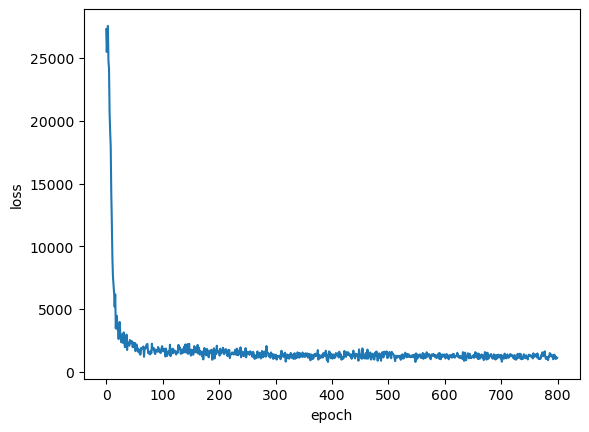

In [100]:
mnet=get_net(n_feature,n_hidden)
train_loss = train(mnet, train_features, train_labels, num_epochs, bs, lr)


# plot the training loss
plt.plot(train_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


# Calculate the log absolute error of the model m

In [101]:
res_train_labels = torch.log((mnet(train_features)-train_labels).abs()).detach()
res_val_labels = torch.log((mnet(val_features)-val_labels).abs()).detach()

# Use the calculated log absolute error of the model m to train the model sigma

In [102]:
dnet=get_net(n_feature,n_hidden)
train(dnet,train_features,res_train_labels, num_epochs, bs, lr)

[9.990924835205078,
 7.428111553192139,
 4.619626045227051,
 2.1700515747070312,
 2.111633539199829,
 1.9649312496185303,
 1.6571812629699707,
 2.059873580932617,
 1.3756052255630493,
 1.9520479440689087,
 1.75809645652771,
 1.663832664489746,
 1.3930222988128662,
 1.4081974029541016,
 1.1181870698928833,
 2.113006830215454,
 2.00734543800354,
 1.3820528984069824,
 1.5438199043273926,
 1.498877763748169,
 1.1737474203109741,
 1.6056358814239502,
 1.418251872062683,
 1.3942643404006958,
 1.3385950326919556,
 1.3309720754623413,
 1.6414709091186523,
 1.188468098640442,
 1.1939042806625366,
 1.3727439641952515,
 1.4394879341125488,
 1.3427729606628418,
 1.5894579887390137,
 1.3076155185699463,
 1.2494521141052246,
 1.001084327697754,
 1.2463335990905762,
 1.6868762969970703,
 1.9452800750732422,
 1.1741344928741455,
 2.1203348636627197,
 1.6324609518051147,
 1.2789956331253052,
 1.3221102952957153,
 1.9081652164459229,
 1.715692400932312,
 2.2492330074310303,
 1.6261522769927979,
 1.61064

# Display the result

In [103]:
ac, inef= test_cp(mnet,dnet, cal_features,cal_labels, test_features, test_labels, 0.5)
print("PICP: "+str(ac))
print("MPIW: "+str(inef))

# teat on train data
ac, inef= test_cp(mnet,dnet, cal_features,cal_labels, train_features, train_labels, 0.9)
print("PICP: "+str(ac))
print("MPIW: "+str(inef))

PICP: 0.5031059170351653
MPIW: 36.449241638183594
PICP: 0.9001500513333509
MPIW: 72.04930114746094


In [104]:
# smooth the curves (the size of the data should not be changed)
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.concatenate((ret[:n-1] / np.arange(1, n), ret[n - 1:] / n))

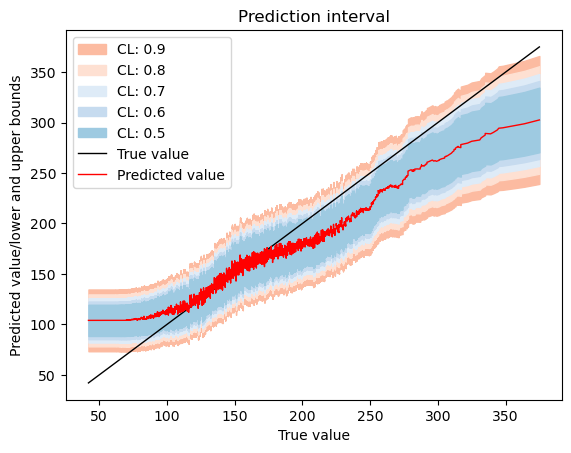

In [105]:
def plot_multipel_interval(mnet,dnet, cal_features,cal_labels, test_features, test_labels, cl1, cl2, cl3, cl4, cl5):
    mnet.eval()
    dnet.eval()
    alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9]
    # lighter color to deeper color according to the hue of the color
    colors = [(0.988,0.733,0.631), (0.996,0.878,0.824), (0.87,0.922,0.969), (0.776,0.859,0.937), (0.62,0.792,0.882)]
    # reverse the list
    #colors = colors[::-1]
    cl_list = [cl1, cl2, cl3, cl4, cl5]
    for i in range(5):
        cl = cl_list[i]
        alphaq = torch.quantile(torch_ncm(mnet,dnet, cal_features, cal_labels), cl)
        lower, upper = regions(mnet,dnet, test_features, test_labels, alphaq)
        y = test_labels.detach().numpy().reshape(-1)
        lower = lower.reshape(-1)
        upper = upper.reshape(-1)
        
        line1 = np.vstack((y, lower)).T
        line2 = np.vstack((y, upper)).T
        
        line1 = line1[np.argsort(line1[:, 0])]
        line2 = line2[np.argsort(line2[:, 0])]
        
        predictions = (lower + upper) / 2
        line3 = np.vstack((y, predictions)).T
        line3 = line3[np.argsort(line3[:, 0])]
        
        # the second argument is the size of the moving average window, the larger the smoother
        line1[:, 1] = moving_average(line1[:, 1], 30)
        line2[:, 1] = moving_average(line2[:, 1], 30)
        line3[:, 1] = moving_average(line3[:, 1], 30)
        
        
        
        plt.fill_between(line1[:, 0], line1[:, 1], line2[:, 1], color=colors[i], alpha=1, label='CL: '+str(cl_list[i]))
        
        if cl == cl5:
            plt.plot(line1[:, 0], line1[:, 0], color='black', linewidth=1, label='True value')
            plt.plot(line3[:, 0], line3[:, 1], color='red', linewidth=1, label='Predicted value')
        
    
    plt.xlabel('True value')
    plt.ylabel('Predicted value/lower and upper bounds')
    plt.title('Prediction interval')
    plt.legend()
    plt.show()

    
    

    



plot_multipel_interval(mnet,dnet, cal_features,cal_labels, test_features, test_labels, 0.9, 0.8, 0.7, 0.6, 0.5)


In [107]:
#mse = loss(mnet(test_features),test_labels).item()
# MAE
mae = (mnet(test_features)-test_labels).abs().mean().item()
print("MAE: "+str(mae))

MAE: 18.98760986328125


In [108]:
#MAE
MAE = mnet(test_features).detach().numpy() - test_labels.detach().numpy()
MAE = np.mean(np.abs(MAE))
print("MAE: "+str(MAE))

MAE: 18.98761
